<center><h1 style="color:#173F8A;"> Metodos para Ecuaciones Diferenciales, IMT3410, 2022-2 </h1></center>
<h3 style="color:#173F8A;text-align:right;"> Instituto de Ingenieria Matematica y Computacional<br>  Pontificia Universidad Catolica de Chile <br>  </h3>
<h3 style="color:#0176DE;text-align:right;"> Profesor. Manuel A. Sanchez<br> </h3>
<hr style="border:2px solid #03122E"> </hr>

<!-- Palette colors UC: celeste:#0176DE, azul #173F8A, azul oscuro: #03122E, amarillo: #FEC60D, amarillo oscuro: #E3AE00 -->
<!--
<figure>
<img align ="right" src="IMClogo.png" alt="logo" width="250" height="400"><br><br><br><br><br>
</figure>
 -->

<h2 style="color:#03122E;text-align:center;"> Capitulo 2. Metodos para Ecuaciones Diferenciales Parciales Elipticas<br> </h2>

<hr style="border:3px solid #E3AE00 "> </hr>

## Ecuacion de 2do orden eliptica


Queremos resolver la siguiente ecuacion eliptica
$$
-\frac{d}{dx}\left( p(x) \frac{d}{dx}u(x)\right) + q(x)\frac{d}{dx}u(x)+ r(x)u(x) = f(x),\quad x\in (a,b)
$$
con condiciones de borde $u(a) = A, u(b) = B$.



In [25]:
# use netgen.meshing module for 1d meshes
from ngsolve import *
from netgen.meshing import Mesh as Mesh1d
from netgen.meshing import MeshPoint,Element0D, Element1D
from netgen.csg import *
import numpy as np
import matplotlib as plt

In [30]:
# Problem data
## New problem
a = 0.0; b= 1.0
f = 1.0 
A = .0; B = .0
p = 1.0
r = 10.0
q = 20.0

In [31]:
from ngsolve import *
def uniform_1d_mesh(a=0.0,b=1.0,N=10, material='material'):
    """ returns a mesh of interval (a,b) with nel elements
    """
    #m = Mesh()
    m = Mesh1d(dim=1)
    pnums = []
    for i in range(0, N+1):
        xi = (b-a)*i/N
        pnums.append (m.Add (MeshPoint (Pnt(xi, 0, 0))))
    idx = m.AddRegion("material", dim=1)
    for i in range(0,N):
        m.Add (Element1D ([pnums[i],pnums[i+1]], index=idx))

    idx_left = m.AddRegion("left", dim=0)
    idx_right = m.AddRegion("right", dim=0)

    m.Add (Element0D (pnums[0], index=idx_left))
    m.Add (Element0D (pnums[N], index=idx_right))

    return m, pnums


In [32]:
m, pnums = uniform_1d_mesh(a=a,b=b,N=20)
mesh = Mesh(m)

In [34]:
# Finite Element Space
Vh = H1(mesh, order=1, dirichlet="left|right")
uh, v = Vh.TnT()
# bilinear form
abf = BilinearForm(Vh)
abf += p*grad(uh)*grad(v)*dx
abf += q*grad(uh)*v*dx
abf += r*uh*v*dx
abf.Assemble()
# linear form
flf = LinearForm(Vh)
flf += f*v*dx
flf.Assemble()

gf = GridFunction(Vh,"u")
gf.Set(0, BND)
rhs = flf.vec.CreateVector()
rhs.data = flf.vec - abf.mat * gf.vec
gf.vec.data += abf.mat.Inverse(Vh.FreeDofs()) * rhs

## Grafica de la solucion en dimension 1

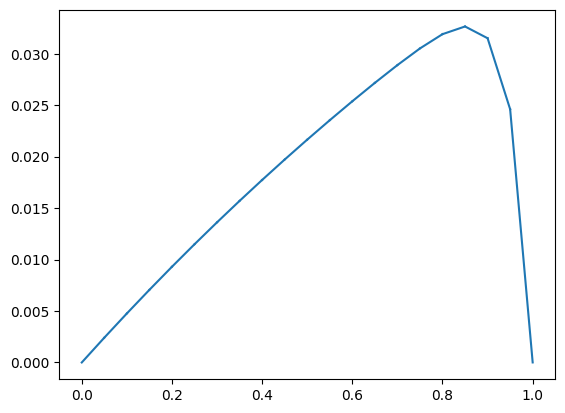

In [35]:
import numpy as np
import matplotlib.pyplot as plt
#plt.rc('text', usetex=True)
# mesh

xx  = [v.point[0] for v in mesh.vertices] 
u0 = [0          for v in mesh.vertices]

fig, ax = plt.subplots(1,1)
uhplot = []
subdiv = 1
for el in mesh.Elements(VOL):
    xvlocal = np.linspace( mesh[el.vertices[0]].point[0]+10**-5, mesh[el.vertices[1]].point[0]-10**-5, subdiv+1)
    uhlocal = []
    for xlocal in xvlocal:
        mip = mesh(xlocal)
        uhlocal.append(gf(mip))
    line_uh, = ax.plot(xvlocal, uhlocal, color='C0')
line_uh.set_label(r'$u_h$')

plt.show()

## Ecuacion de Poisson 

Resolvemos el problema de Poisson en dimension 2:
\begin{equation}
\begin{array}{rclrl}
-\nabla \cdot( \nabla u(x,y))&=& f(x,y)&\mbox{en} & (a,b) \\
u &=&u_D&\mbox{sobre}& \{a,b\}
\end{array}
\end{equation}

In [37]:
from ngsolve import * # libreria de NGVolve
from netgen.geom2d import unit_square # dominio
from ngsolve.webgui import Draw # comando para graficar en jupyter

ngsglobals.msg_level = 1

# generate a triangular mesh of mesh-size 0.2
mesh = Mesh(unit_square.GenerateMesh(maxh=0.075))

# H1-conforming finite element space
fes = H1(mesh, order=1, dirichlet=[1,2,3,4])

# define trial- and test-functions
u = fes.TrialFunction()
v = fes.TestFunction()

# the right hand side
force = IfPos(x-0.15,IfPos(0.35-x,IfPos(0.35-y,IfPos(y-0.15,1,0),0),0),0) + IfPos(x-0.65,IfPos(0.85-x,IfPos(0.85-y,IfPos(y-0.65,1,0),0),0),0) + IfPos(x-0.65,IfPos(0.85-x,IfPos(0.35-y,IfPos(y-0.15,1,0),0),0),0) + IfPos(x-0.15,IfPos(0.35-x,IfPos(0.85-y,IfPos(y-0.65,1,0),0),0),0)

f = LinearForm(fes)
f += force * v * dx

# the bilinear-form 
a = BilinearForm(fes, symmetric=True)
a += grad(u)*grad(v)*dx

a.Assemble()
f.Assemble()

# the solution field 
gfu = GridFunction(fes)
gfu.vec.data = a.mat.Inverse(fes.FreeDofs(), inverse="sparsecholesky") * f.vec
# print (u.vec)


# plot the solution (netgen-gui only)
Draw(force, mesh)
Draw (gfu)
#Draw (-grad(gfu), mesh, "Flux")


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

BaseWebGuiScene